# Task 2
## Data Analysis

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display

from scipy.stats import shapiro

import folium
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [2]:
DATA_DIR = Path("..", "data")
RAW, OUT = DATA_DIR / "raw", DATA_DIR / "processed"

## Load preprocessed Datasets

In [3]:
df_nasdaq_daily_pp = pd.read_csv(OUT / "df_nasdaq_daily.csv", keep_default_na=False)
df_nasdaq_daily_pp["date"] = pd.to_datetime(df_nasdaq_daily_pp["date"])

df_nasdaq_weekly_pp = pd.read_csv(OUT / "df_nasdaq_weekly.csv", keep_default_na=False)

df_crypto_daily_pp = pd.read_csv(OUT / "df_crypto_daily.csv", keep_default_na=False)
df_crypto_daily_pp["date"] = pd.to_datetime(df_crypto_daily_pp["date"])

df_crypto_weekly_pp = pd.read_csv(OUT / "df_crypto_weekly.csv", keep_default_na=False)

df_nasdaq_meta_pp = pd.read_csv(OUT / "df_nasdaq_meta.csv", keep_default_na=False)

## NASDAQ Stocks: Industry & Lifetime


### Lifetime
Histogram that shows the Distribution

3343 Stocks have been listed in the NASDAQ Index.
Average lifetime of a company in NASDAQ: 12.01 years


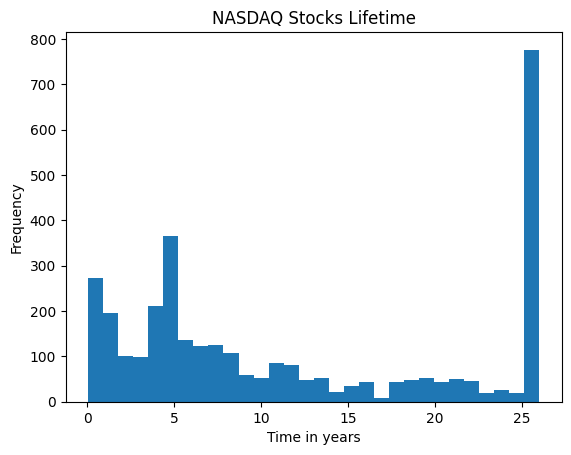

In [4]:
print(f"{len(df_nasdaq_daily_pp["ticker"].unique())} Stocks have been listed in the NASDAQ Index.")

df_nasdaq_first_last = (df_nasdaq_daily_pp.groupby("ticker")["date"]
                        .agg(firstdate="min", lastdate="max")
                        .reset_index()
                        )

df_nasdaq_first_last["lifetime"] = (df_nasdaq_first_last["lastdate"] - df_nasdaq_first_last["firstdate"]).dt.days / 365
print(f"Average lifetime of a company in NASDAQ: {df_nasdaq_first_last["lifetime"].mean():.2f} years")

df_nasdaq_first_last["lifetime"].plot.hist(
    title="NASDAQ Stocks Lifetime",
    xlabel="Time in years",
    bins=30,
)
plt.show()


## Active Stocks
The amount of active stocks each is will be determined. The result is plotted.<br>
The assumption, the NASDAQ Composite has been growing, is wrong.<br>
Our Internet researches have shown that there have been more stocks earlier that aren't mentioned in this dataset.

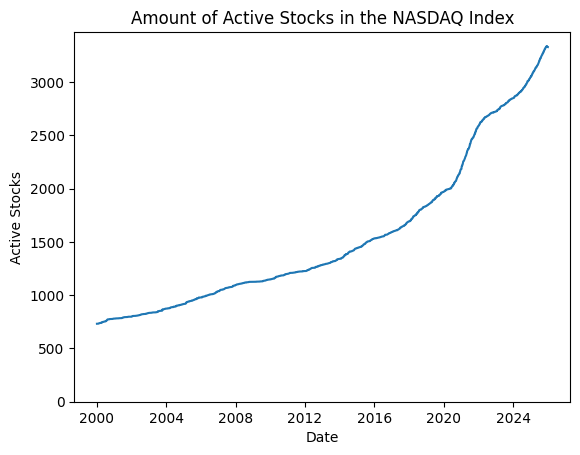

In [5]:
nasdaq_first_date = df_nasdaq_daily_pp["date"].min()
nasdaq_last_date = df_nasdaq_daily_pp["date"].max()

dates_between = pd.date_range(nasdaq_first_date, nasdaq_last_date, freq='D')

# count active tickers per day
counts = pd.Series(dates_between).apply(lambda d: ((df_nasdaq_first_last["firstdate"] <= d) & (df_nasdaq_first_last["lastdate"] >= d)).sum())

plt.plot(dates_between, counts)
plt.xlabel('Date')
plt.ylabel('Active Stocks')
plt.title("Amount of Active Stocks in the NASDAQ Index")
plt.ylim(0)
plt.show()

### Industry Changes
We compare branches every fifth year.<br>
Health care has grown extremely. Companies in the sector Consumer Discretionary, Technology and Finance have also noticeably

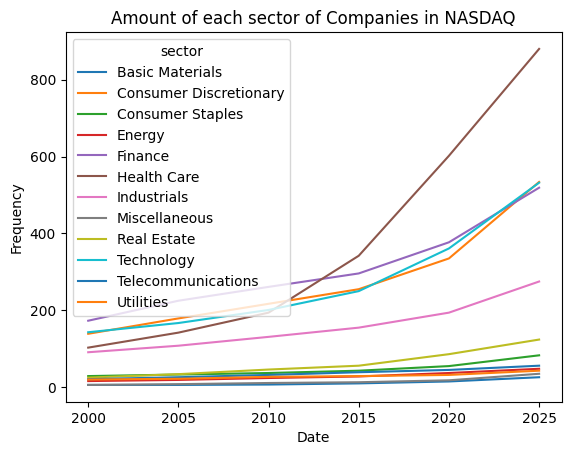

,2000,2005,2010,2015,2020,2025
sector,,,,,,
Basic Materials,6,6,7,10,15,26
Consumer Discretionary,139,179,217,255,335,534
Consumer Staples,29,33,37,43,55,83
Energy,16,19,24,28,37,48
Finance,173,225,261,296,377,519
Health Care,103,142,194,342,602,880
Industrials,91,108,131,155,194,275
Miscellaneous,6,8,11,13,18,35
Real Estate,25,34,46,56,86,124


In [6]:
INDUSTRY_COL = "sector"   # "sector" or "industry" - Select the column to analyze. Sector has less unique values - Industry is more specific

def getIndustry(year: int) -> pd.Series:
    """
    Counts the active companies of each industry in the specific year
    :return: industry -> amount - Series
    """
    df_active = df_nasdaq_daily_pp[df_nasdaq_daily_pp["date"].dt.year == year]
    s_industry = df_nasdaq_meta_pp.set_index("ticker")
    s_industry = s_industry.reindex(df_active["ticker"].unique())[INDUSTRY_COL]
    return s_industry[s_industry != ""].value_counts()


selected_years = pd.date_range(str(nasdaq_first_date.year), str(nasdaq_last_date.year), freq="5YS").year

df_nasdaq_industry = pd.DataFrame({
    year: getIndustry(year)
    for year in selected_years
})

if INDUSTRY_COL == "sector":
    df_nasdaq_industry.T.plot.line(
        xlabel="Date",
        ylabel="Frequency",
        title="Amount of each sector of Companies in NASDAQ"
    )
    plt.show()

df_nasdaq_industry

## NASDAQ Winning Stocks per Year

In [7]:
df_nasdaq_yearly = df_nasdaq_daily_pp.copy()

df_nasdaq_yearly["year"] = df_nasdaq_yearly["date"].dt.year

df_nasdaq_yearly = (
    df_nasdaq_yearly.groupby(["ticker", "year"])["close"]
      .agg(start="first", end="last")
      .reset_index()
)

df_nasdaq_yearly["win"] = df_nasdaq_yearly["end"] > df_nasdaq_yearly["start"]
df_nasdaq_yearly["difference"] = df_nasdaq_yearly["end"] - df_nasdaq_yearly["start"]

s_wins_per_year = df_nasdaq_yearly.groupby("year")["win"].mean()
s_difference_per_year = df_nasdaq_yearly.groupby("year")["difference"].mean()

df_nasdaq_win = pd.DataFrame({"Win Percentage": s_wins_per_year * 100, "Avg Difference": s_difference_per_year})

bestyear = s_wins_per_year.idxmax()
print("Best Year (most companies won):", bestyear)

df_nasdaq_win

Best Year (most companies won): 2003


,Win Percentage,Avg Difference
year,,
2000,33.717949,-3.731942e+07
2001,65.162907,-9.325230e+06
2002,41.726619,-1.460655e+06
2003,86.613272,2.951715e+06
2004,63.904035,-2.829727e+06
2005,39.632278,-4.846793e+05
2006,66.730955,-8.869356e+04
2007,38.868613,-5.529138e+04
2008,13.511111,-1.080595e+07


## Crypto Winning Stocks per Year

In [8]:
df_crypto_yearly = df_crypto_daily_pp.copy()

df_crypto_yearly["year"] = df_crypto_yearly["date"].dt.year

df_crypto_yearly = (
    df_crypto_yearly.groupby(["ticker", "year"])["close"]
      .agg(start="first", end="last")
      .reset_index()
)

df_crypto_yearly["win"] = df_crypto_yearly["end"] > df_crypto_yearly["start"]
df_crypto_yearly["difference"] = df_crypto_yearly["end"] - df_crypto_yearly["start"]

s_crypto_wins_per_year = df_crypto_yearly.groupby("year")["win"].mean()
s_crypto_difference_per_year = df_crypto_yearly.groupby("year")["difference"].mean()

df_crypto_win = pd.DataFrame({"Win Percentage": s_crypto_wins_per_year * 100, "Avg Difference": s_crypto_difference_per_year})

df_crypto_win

,Win Percentage,Avg Difference
year,,
2010,100.000000,0.250490
2011,100.000000,4.420000
2012,100.000000,8.240000
2013,100.000000,406.595000
2014,33.333333,-172.936667
2015,50.000000,14.378754
2016,70.000000,-439.323665
2017,100.000000,577.257772
2018,14.583333,-315.149808


### Plot: Compare NASDAQ to Crypto
It's clear that the average return of cryptocurrencies changes dramatically. The effects of the 2008 global financial crisis and the "Corona years" are clearly visible in the NASDAQ, where the average annual price change falls sharply into negative territory.<br>
We see that the crypto graph has the same tendencies as the NASDAQ graph - just more extreme.

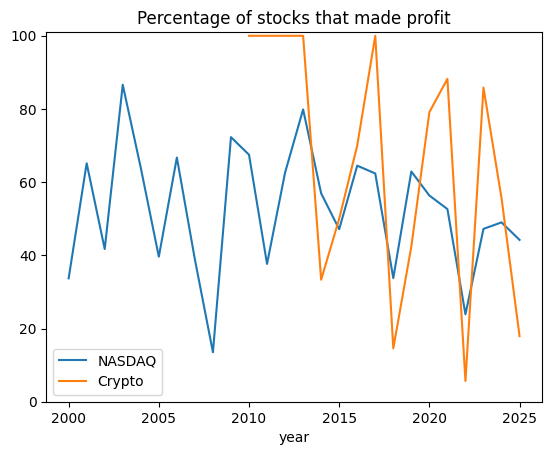

In [9]:
pd.DataFrame({"NASDAQ": df_nasdaq_win["Win Percentage"], "Crypto": df_crypto_win["Win Percentage"]}).plot.line(
    title="Percentage of stocks that made profit",
    ylim=(0, 101)
)
plt.show()

## Statistical Distribution of Closing Prices

c:\Users\Matti\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


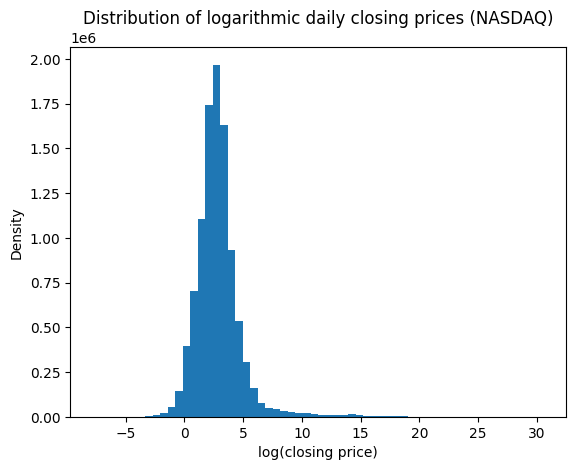

Shapiro-Wilk Statistic: 0.8224
p-Wert: 2.3043e-59


In [10]:
df_distribution = df_nasdaq_daily_pp.copy()

df_distribution["log_close"] = np.log(df_distribution["close"])

plt.hist(df_distribution["log_close"], bins=60)
plt.xlabel("log(closing price)")
plt.ylabel("Density")
plt.title("Distribution of logarithmic daily closing prices (NASDAQ)")
plt.show()

# Achtung: Shapiro ist für sehr große n problematisch
sample = df_distribution["log_close"].sample(5000, random_state=42)

stat, p_value = shapiro(sample)

print(f"Shapiro-Wilk Statistic: {stat:.4f}")
print(f"p-Wert: {p_value:.4e}")

## Correlation Analysis
Specific stocks are compared to each other over the maximum timespan<br>
Here we can see strong correlations between every stock.<br>
All values are between 0.72 and 0.95.<br>
But this is not surprising. Because good phases and bad phases have affects on almost the whole economy.<br>
Interesting is that the cryptocurrencies are also correlating.

In [11]:
# NAME = <Ticker>, <is Crypto>
BITCOIN = "BTC", True
ETHEREUM = "ETH", True
NVIDIA = "NVDA", False
MICROSOFT = "MSFT", False
AMAZON = "AMZN", False
TESLA = "TSLA", False

STOCKS: list[tuple[str, bool]] = [BITCOIN, ETHEREUM, NVIDIA, MICROSOFT, AMAZON, TESLA]      # Can be changed

stock_serieses = []

for s in STOCKS:
    if s[1]:
        df = df_crypto_daily_pp
    else:
        df = df_nasdaq_daily_pp

    ser = df[df["ticker"] == s[0]][["date", "close"]].set_index("date")["close"]
    ser.name = s[0]
    stock_serieses.append(ser)


df_compare = pd.concat(stock_serieses, axis=1)
df_corr = df_compare.corr()
df_corr




,BTC,ETH,NVDA,MSFT,AMZN,TSLA
BTC,1.000000,0.875476,0.927501,0.922747,0.881817,0.884612
ETH,0.875476,1.000000,0.736166,0.889319,0.836713,0.881153
NVDA,0.927501,0.736166,1.000000,0.862261,0.777069,0.765824
MSFT,0.922747,0.889319,0.862261,1.000000,0.960153,0.922283
AMZN,0.881817,0.836713,0.777069,0.960153,1.000000,0.890217
TSLA,0.884612,0.881153,0.765824,0.922283,0.890217,1.000000


### Visualization

In [12]:
fig = go.Figure(
    data=go.Heatmap(
        z=df_corr.values,
        x=df_corr.columns,
        y=df_corr.index,
        colorscale="RdBu",
        zmin=-1,
        zmax=1,
        hovertemplate=
        "Stocks X: %{x}<br>" +
        "Stocks Y: %{y}<br>" +
        "Korrelation: %{z:.2f}<extra></extra>"
    )
)

fig.update_layout(
    title="Korrelationsmatrix: Bitcoin, Ethereum & NASDAQ-Aktien",
    xaxis_title="Assets",
    yaxis_title="Assets"
)

fig.show()

## Stock Returns
Every month, on the first day, €100 is invested in the respective stock.

In [13]:
START_DATE = pd.to_datetime("01.01.2020")
INVEST = 100    # in Euros

df_nasdaq_monthly = df_nasdaq_daily_pp.copy()
df_nasdaq_monthly = df_nasdaq_monthly[df_nasdaq_monthly["date"] >= START_DATE]
df_nasdaq_monthly["month"] = df_nasdaq_monthly["date"].dt.to_period("M")
df_nasdaq_monthly = (df_nasdaq_monthly
                     .groupby(["ticker", "month"])["close"]
                     .first()
                     .reset_index(["month"]))

df_nasdaq_monthly["count"] = INVEST / df_nasdaq_monthly["close"]
print(df_nasdaq_monthly.head())

print("-------------------------------")

s_nasdaq_last = df_nasdaq_daily_pp.groupby(["ticker"])["close"].last()
s_nasdaq_last.name = "Last Value"
s_nasdaq_count = df_nasdaq_monthly.groupby(["ticker"])["count"].sum()
s_nasdaq_count.name = "Count"

df_nasdaq_rendite = pd.concat([s_nasdaq_last, s_nasdaq_count], axis=1)
df_nasdaq_rendite["Rendite"] = s_nasdaq_last * s_nasdaq_count



df_highest_rendite = df_nasdaq_rendite.nlargest(2, "Rendite")
print(f"Höchste Rendite: {df_highest_rendite.iloc[0].name} mit {df_highest_rendite.iloc[0]["Rendite"]:.2f} €")
print(f"Zweit Höchste Rendite: {df_highest_rendite.iloc[1].name} mit {df_highest_rendite.iloc[1]["Rendite"]:.2f} €")

df_nasdaq_rendite

          month  close      count
ticker                           
AACB    2025-04   9.88  10.121457
AACB    2025-05   9.98  10.020040
AACB    2025-06  10.09   9.910803
AACB    2025-07  10.12   9.881423
AACB    2025-08  10.14   9.861933
-------------------------------
Höchste Rendite: PPCB mit 533095.88 €
Zweit Höchste Rendite: GSAT mit 407864.11 €


,Last Value,Count,Rendite
ticker,,,
AACB,10.300,88.988576,916.582330
AACG,0.790,5948.153244,4699.041063
AAL,15.330,503.607795,7720.307499
AAME,2.830,3198.216503,9050.952703
AAOI,34.860,1226.248375,42747.018340
...,...,...,...
ZURA,5.240,1205.478814,6316.708986
ZVRA,8.960,1128.397406,10110.440755
ZYBT,1.150,278.010794,319.712413


In [14]:
START_DATE = pd.to_datetime("01.01.2020")
INVEST = 100    # in Euros

df_crypto_monthly = df_crypto_daily_pp.copy()
df_crypto_monthly = df_crypto_monthly[df_crypto_monthly["date"] >= START_DATE]
df_crypto_monthly["month"] = df_crypto_monthly["date"].dt.to_period("M")
df_crypto_monthly = (df_crypto_monthly
                     .groupby(["ticker", "month"])["close"]
                     .first()
                     .reset_index(["month"]))

df_crypto_monthly["count"] = INVEST / df_crypto_monthly["close"]
print(df_crypto_monthly.head())

print("-------------------------------")

s_crypto_last = df_crypto_daily_pp.groupby(["ticker"])["close"].last()
s_crypto_last.name = "Last Value"
s_crypto_count = df_crypto_monthly.groupby(["ticker"])["count"].sum()
s_crypto_count.name = "Count"

df_crypto_rendite = pd.concat([s_crypto_last, s_crypto_count], axis=1)
df_crypto_rendite["Rendite"] = s_crypto_last * s_crypto_count

print(f"Höchste Rendite: {df_crypto_rendite["Rendite"].idxmax()} mit {df_crypto_rendite["Rendite"].max():.2f} €")

df_crypto_rendite

          month    close      count
ticker                             
1INCH   2020-12  2.32854  42.945365
1INCH   2021-01  1.15538  86.551611
1INCH   2021-02  5.05300  19.790224
1INCH   2021-03  4.10300  24.372410
1INCH   2021-04  4.44800  22.482014
-------------------------------
Höchste Rendite: COMP mit inf €


,Last Value,Count,Rendite
ticker,,,
1INCH,0.14128,1.385211e+04,1957.025757
AAVE,146.15785,2.472745e+02,36141.106889
ADA,0.33283,3.030105e+04,10085.099590
ALGO,0.11027,2.985481e+04,3292.089936
AMP,0.00187,1.298820e+06,2428.793613
...,...,...,...
XRP,1.83997,1.456333e+04,26796.092887
XTZ,0.49435,6.039020e+03,2985.389635
YFI,3260.03638,8.749504e-01,2852.370016


### (Interactive) Plot

In [15]:
def get_rendite(ticker:str, is_crypto:bool, start_date:pd.Timestamp, end_date:pd.Timestamp, invest:int) -> pd.DataFrame:
    """
    :param ticker: Ticker
    :param is_crypto: if the ticker is a cryptocurrency
    :param start_date: from
    :param end_date: to
    :param invest: monthly invested amount
    :return: DataFrame with index month and columns close, count, total_count, value, total_invest
    """

    if is_crypto:
        df_rendite = df_crypto_daily_pp.copy()
    else:
        df_rendite = df_nasdaq_daily_pp.copy()

    if ticker not in df_rendite["ticker"].values:
        raise RuntimeError("Invalid Ticker. Check ticker and IS_CRYPTO")

    df_rendite = df_rendite[(df_rendite["ticker"] == ticker) & (df_rendite["date"].between(start_date, end_date))]
    df_rendite = df_rendite.drop(["ticker", "open"], axis=1)
    df_rendite["month"] = df_rendite["date"].dt.to_period("M")
    df_rendite = df_rendite.groupby(["month"]).first()
    df_rendite = df_rendite.drop("date", axis=1)

    df_rendite["count"] = invest / df_rendite["close"]
    df_rendite["total_count"] = df_rendite["count"].cumsum()
    df_rendite["value"] = df_rendite["total_count"] * df_rendite["close"]
    df_rendite["total_invest"] = np.arange(1, len(df_rendite) + 1) * 100

    return df_rendite

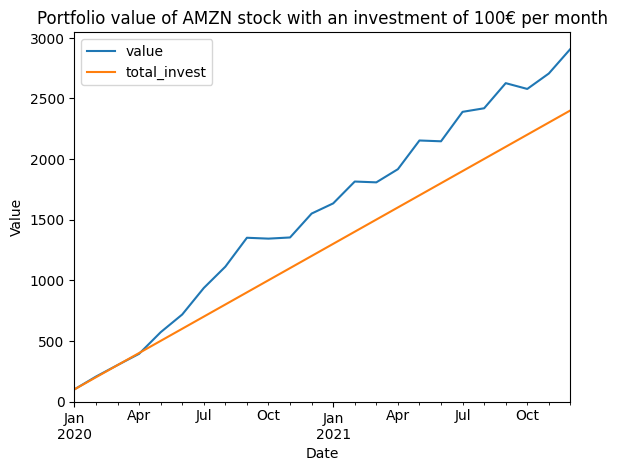

In [16]:
# MatPlotLib

TICKER = "AMZN"
IS_CRYPPTO = False
START_DATE = pd.to_datetime("1.1.2020")
END_DATE = pd.to_datetime("1.1.2022")
INVEST = 100    # in Euros

df_rendite = get_rendite(TICKER, IS_CRYPPTO, START_DATE, END_DATE, INVEST)

p = df_rendite[["value", "total_invest"]].plot.line(
    title=f"Portfolio value of {TICKER} stock with an investment of {INVEST}€ per month",
    xlabel="Date",
    ylabel="Value",
    ylim=(0, None)
)
plt.show()


In [17]:
INVEST = 100    # in Euros

ticker_widget = widgets.Text(value="MSFT", description="Ticker:")
crypto_widget = widgets.Checkbox(value=False, description="Crypto")
start_date_widget = widgets.DatePicker(description="Start", value=pd.Timestamp(year=2020, month=1, day=1))
end_date_widget = widgets.DatePicker(description="End", value=pd.Timestamp.today())
update_button = widgets.Button(description="Update", button_style="primary")

fig = go.FigureWidget()
fig.update_layout(
    title="Rendite",
    xaxis_title="Date",
    yaxis_title="Value"
)

fig.update_xaxes(
    tickmode="array",
    tickvals=None
)


def update_plot(_=None):
    start_ts = pd.Timestamp(start_date_widget.value)
    end_ts = pd.Timestamp(end_date_widget.value)

    df = get_rendite(
        ticker_widget.value,
        crypto_widget.value,
        start_ts,
        end_ts,
        INVEST
    )

    df.index = df.index.to_timestamp()
    x_vals = df.index.strftime("%Y-%m")

    with fig.batch_update():
        fig.data = tuple()

        fig.add_scatter(
            x=x_vals,
            y=df["value"],
            mode="lines",
            name="Rendite"
        )

        fig.add_scatter(
            x=x_vals,
            y=df["total_invest"],
            mode="lines",
            name="Total Invest"
        )

        fig.layout.title = (
            f"{ticker_widget.value} "
            f"({'Crypto' if crypto_widget.value else 'Stock'})"
        )



update_button.on_click(update_plot)

controls = widgets.VBox([
    ticker_widget,
    crypto_widget,
    start_date_widget,
    end_date_widget,
    update_button
])

display(widgets.HBox([controls, fig]))

update_plot()

## Geo Map

In [18]:
# Filter non US States and remove empty addresses
df_meta = df_nasdaq_meta_pp.copy()[df_nasdaq_meta_pp["country"] == "United States"]
df_meta = df_meta[df_meta["address"] != ""]

Get Coordinates of each city.<br>
Because of the rate limits this took 2:44h. So I saved the result into `df_nasdaq_loc.csv` and commented the code out.

In [19]:
# df_loc = df_meta.copy()
# df_loc["city"] = df_loc["address"].str.split(r",\s*").str[-4:-2].str.join(", ")
# df_loc = df_loc[["ticker", "city"]]
#
# geolocator = Nominatim(user_agent="nasdaq_geo_analysis")
# geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
#
# df_loc["geocode"] = df_loc["city"].apply(geocode)
# df_loc = df_loc[df_loc["geocode"].notna()]
# df_loc["latitude"] = df_loc["geocode"].apply(lambda loc: loc.latitude)
# df_loc["longitude"] = df_loc["geocode"].apply(lambda loc: loc.longitude)
#
# df_loc = df_loc.drop(["geocode", "city"], axis=1)
#
# df_loc.to_csv(OUT / "df_nasdaq_loc.csv", index=False)

pass


In [20]:
df_loc = pd.read_csv(OUT / "df_nasdaq_loc.csv")
df_loc = df_loc.merge(df_meta[["ticker", "address"]], on="ticker", how="left")

m = folium.Map(
    location=[39.5, -98.35],
    zoom_start=4,
    tiles="CartoDB positron"
)

for _, row in df_loc.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=4,
        popup=f"Ticker: {row['ticker']}<br>Address: {row['address']}",
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

m

Some Companies have the country attribute wrongly set to the United States, so we can see them. But to filter them would take too much time.<br>
We see that the NASDAQ companies are spreaded over the US (except some States like Wyoming) but tend to be more on the east of America.<br>
There are some areas where companies are concentrated, like New York, Chicago, San Francisco (Silicon Valley), Los Angeles, Seattle and Denver.<br>

## Own Idea
### Stock Price Fluctuations

We want to determine the NASDAQ stocks with the most price fluctuations.<br>
We take the mean of the daily change - based of the day before, so no the stock lifetime doesn't have an affect.<br>
Stocks where the amount of entries in the NASDAQ Daily less than 50 are filtered.<br>
The distribution of stocks with a fluctuation up to 15% and the stock with the most and least fluctuations is plotted.

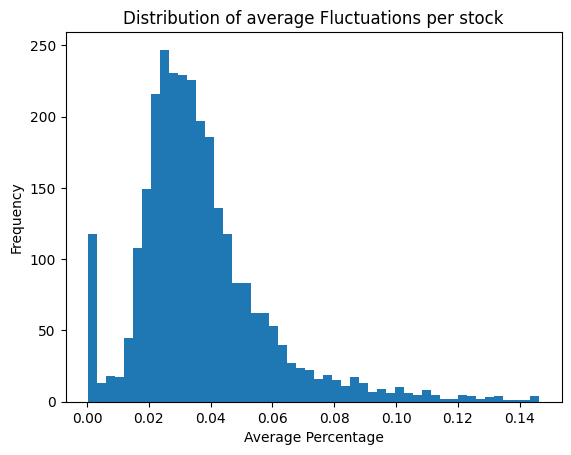

-------------------------------------------------
The average fluctuation is 3871.74%
-------------------------------------------------


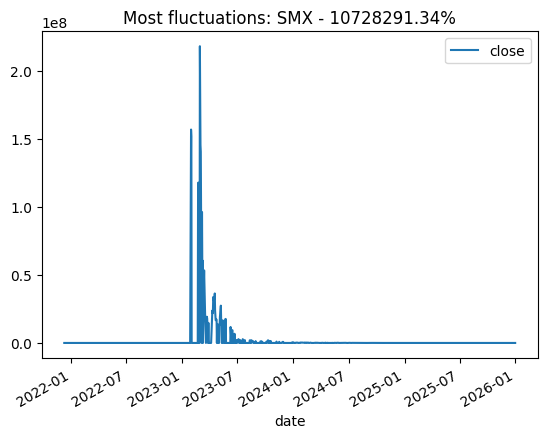

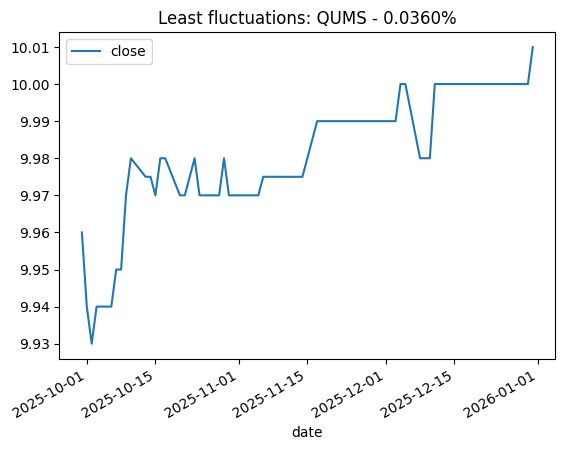

ticker
AACB    0.000920
AACG    0.077252
AAL     0.027570
AAME    0.036051
AAOI    0.036097
          ...   
ZURA    0.050020
ZVRA    0.034642
ZYBT    0.078495
ZYME    0.027433
ZYXI    0.119071
Name: change, Length: 3343, dtype: float64

In [21]:
df_fluct = df_nasdaq_daily_pp[["ticker", "date", "close"]]
df_fluct["change"] = df_fluct.groupby("ticker")["close"].pct_change().abs()
df_fluct = df_fluct.groupby("ticker")["change"].mean()
df_fluct_filtered = df_fluct[df_nasdaq_daily_pp.groupby("ticker").size() >= 50]

df_fluct_filtered[df_fluct_filtered <= 0.15].plot.hist(
    title="Distribution of average Fluctuations per stock",
    xlabel="Average Percentage",
    bins=50
)
plt.show()

print("-------------------------------------------------")
print(f"The average fluctuation is {df_fluct.mean() * 100:.2f}%")
print("-------------------------------------------------")

# Stock with the most fluctuations
max_fluc_ticker = df_fluct_filtered.idxmax()
df_max_fluc = df_nasdaq_daily_pp[df_nasdaq_daily_pp["ticker"] == max_fluc_ticker]
df_max_fluc.plot.line(
    x="date",
    y="close",
    title=f"Most fluctuations: {max_fluc_ticker} - {df_fluct[max_fluc_ticker] * 100:.2f}%"
)
plt.show()


# Stock with the least fluctuations
min_fluc_ticker = df_fluct_filtered.idxmin()
df_min_fluc = df_nasdaq_daily_pp[df_nasdaq_daily_pp["ticker"] == min_fluc_ticker]
df_min_fluc.plot.line(
    x="date",
    y="close",
    title=f"Least fluctuations: {min_fluc_ticker} - {df_fluct[min_fluc_ticker] * 100:.4f}%"
)
plt.show()

df_fluct